# Conditional image synthesis with AC-GANs (Auxiliary Classifier GANs)


## 0. Imports

In [ ]:
from __future__ import print_function, division

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Conv2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from keras.datasets import mnist, fashion_mnist, cifar10
import tensorflow_datasets as tfds

from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import pandas as pd

## 1. Utils (plots and metrics)

### 1.1 Plots

In [ ]:
#Show the Generator-Descriminator loss for every epoch
def plot_gan_losses(g_loss, d_loss):
    plt.plot(g_loss)
    plt.plot(d_loss)
    plt.title('GAN Loss evolution')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

In [ ]:
def plot_n_closest(img_smp, id_label_sample, X_train, N_closest, fig_size=(8, 3)):
    #get the images that belong to id_label_sample
    idx_lab = np.where(y_train==id_label_sample)
    X_lab = (X_train[idx_lab, :, :].astype(np.float32) / 255)[0, :, :, :]
    
    #apply the norm between X_lab and the sampled image across all images
    L1d = np.sum(np.apply_along_axis(np.linalg.norm, -1, X_lab - img_smp, ord=1), axis=1)
    idx_l1_sort = L1d.argsort()
    #plt.imshow(X_lab[idx_l1_sort[0], :, :], cmap='gray')
    fig, axs = plt.subplots(1, N_closest, figsize=fig_size)
    for i in range(N_closest):
        axs[i].imshow(X_lab[idx_l1_sort[i], :, :], cmap='gray')
        axs[i].axis('off')
    plt.show()

### Studying overfitting

In [ ]:
ac_gan = AcGan_Cifar(nb_rows=32, nb_columns=32, nb_channels=3, nb_classes=len(label_dict), noise_dim=110)
ac_gan.instanciate_discriminator()
ac_gan.instanciate_generator()
ac_gan.instanciate_combined_model()

In [ ]:
ac_gan.model.load_weights('acgan.h5')

#### Interpolation

In [ ]:
noise_dim = 110

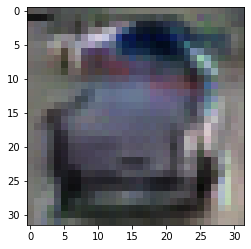

In [ ]:
ac_gan.sample_single_image(np.random.normal(0, 1, (1, noise_dim)), np.array(1).reshape(1, ))



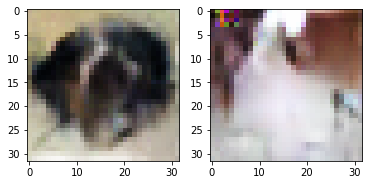

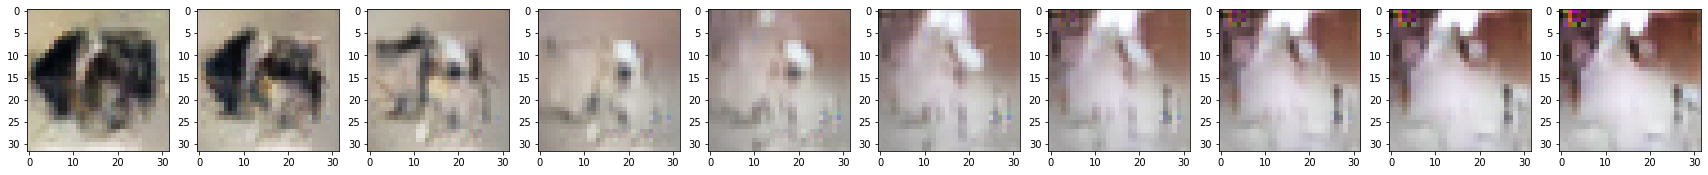

In [ ]:
# Il faut une fonction qui fasse une interpolation entre les deux bruits d'entrée.
import time

def interpolate_points(z1, z2, n_steps=10):
  # interpolate ratios between the points
  vectors = np.linspace(z1,z2, 2+n_steps) # +2 because we don't count z1 and z2
  return vectors[1:-1,:]


# D'abord tirer les deux bruits d'entrée z1 et z2 : 
id_label_sample = 5
noise_dim = 110

#=z#
z1 = np.random.normal(0, 1, (1, noise_dim))
time.sleep(0.2)
z2 = np.random.normal(0, 1, (1, noise_dim))

img_1 = ac_gan.generator.predict([z1, np.array(id_label_sample).reshape(1, )])[0]
img_2 = ac_gan.generator.predict([z2, np.array(id_label_sample).reshape(1, )])[0]

z = interpolate_points(z1, z2)

imgs = []
for noise in z:
  imgs.append( ac_gan.generator.predict([noise, np.array(id_label_sample).reshape(1,)])[0] * 0.5 + 0.5)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(img_1*0.5 + 0.5)
ax2.imshow(img_2*0.5 + 0.5)

fig, axis = plt.subplots(1,10, figsize=(30,20))


for i, ax in enumerate(axis):
  ax.imshow(imgs[i])
  



#### Same style on different classes





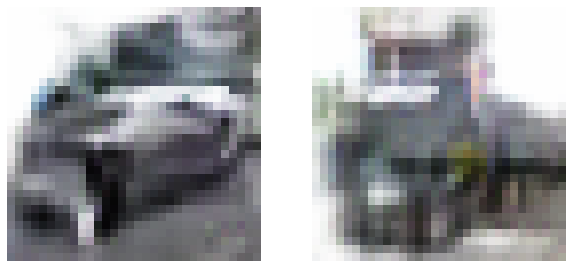

In [ ]:
noise = np.random.normal(0, 1, (1, noise_dim))
imgs = []
for label in [1,9]:
  imgs.append( ac_gan.generator.predict([noise, np.array(label).reshape(1,)])[0] * 0.5 + 0.5)

fig, axis = plt.subplots(1,len(imgs), figsize=(5*len(imgs),5*len(imgs)))

for i, ax in enumerate(axis):
  ax.imshow(imgs[i])
  ax.axis("off")


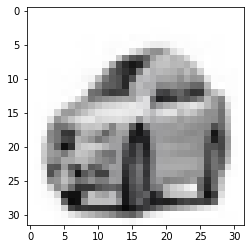

In [ ]:
imm = X_train[160]
plt.imshow(imm)

#### N-closest

[  24 4653  355 ... 2946 4480 2008]


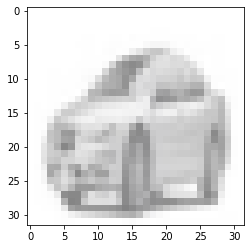

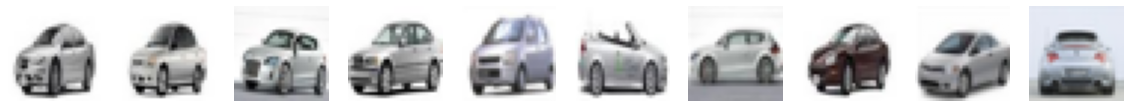

In [ ]:
plot_n_closest_cifar(imm*0.5 + 0.5, 1, X_train, y_train, 10)

In [ ]:
def plot_n_closest_cifar(img_smp, id_label_sample, X_train, y_train, N_closest, fig_size=(20, 20)):
    #get the images that belong to id_label_sample
    idx_lab = np.where(y_train==id_label_sample)
    # print(idx_lab)
    X_lab = (X_train[idx_lab, :, :].astype(np.float32))[0, :, :, :]
    X_lab = (X_lab - 127.5) / 127.5
    X_lab = X_lab*0.5 + 0.5
    # print(X_lab.shape)
    # print(X_lab[0])
    plt.imshow(img_smp*0.5 + 0.5)
    #apply the norm between X_lab and the sampled image across all images
    dist = []
    for image in X_lab:
      dist.append(np.linalg.norm( (image - img_smp).reshape(-1,) ))
    # print('dist',dist)
    #L1d = np.sum(np.apply_over_axis(np.linalg.norm, -1, X_lab - img_smp, ord=1), axis=1)
    #print(L1d)
    idx_l1_sort = np.asarray(dist).argsort()
    print(idx_l1_sort)
    #plt.imshow(X_lab[idx_l1_sort[0], :, :], cmap='gray')
    fig, axs = plt.subplots(1, N_closest, figsize=fig_size)
    for i in range(N_closest):
        axs[i].imshow(X_lab[idx_l1_sort[i]])
        axs[i].axis('off')
    plt.show()

#### MS-SIM

In [ ]:
from tensorflow.image import ssim_multiscale as ms_ssim

In [ ]:
def _tf_fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x_data, y_data = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]

    x_data = np.expand_dims(x_data, axis=-1)
    x_data = np.expand_dims(x_data, axis=-1)

    y_data = np.expand_dims(y_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)

    x = tf.constant(x_data, dtype=tf.float32)
    y = tf.constant(y_data, dtype=tf.float32)

    g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g / tf.reduce_sum(g)


def tf_ssim(img1, img2, cs_map=False, mean_metric=True, size=11, sigma=1.5):
    window = _tf_fspecial_gauss(size, sigma) # window shape [size, size]
    K1 = 0.01
    K2 = 0.03
    L = 1  # depth of image (255 in case the image has a differnt scale)
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    mu1 = tf.nn.conv2d(img1, window, strides=[1,1,1,1], padding='VALID')
    mu2 = tf.nn.conv2d(img2, window, strides=[1,1,1,1],padding='VALID')
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    sigma1_sq = tf.nn.conv2d(img1*img1, window, strides=[1,1,1,1],padding='VALID') - mu1_sq
    sigma2_sq = tf.nn.conv2d(img2*img2, window, strides=[1,1,1,1],padding='VALID') - mu2_sq
    sigma12 = tf.nn.conv2d(img1*img2, window, strides=[1,1,1,1],padding='VALID') - mu1_mu2
    if cs_map:
        value = (((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2)),
                (2.0*sigma12 + C2)/(sigma1_sq + sigma2_sq + C2))
    else:
        value = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2))

    if mean_metric:
        value = tf.reduce_mean(value)
    return value


def tf_ms_ssim(img1, img2, mean_metric=True, level=5):
    weight = tf.constant([0.0448, 0.2856, 0.3001, 0.2363, 0.1333], dtype=tf.float32)
    mssim = []
    mcs = []
    for l in range(level):
        ssim_map, cs_map = tf_ssim(img1, img2, cs_map=True, mean_metric=False)
        mssim.append(tf.reduce_mean(ssim_map))
        mcs.append(tf.reduce_mean(cs_map))
        filtered_im1 = tf.nn.avg_pool(img1, [1,2,2,1], [1,2,2,1], padding='SAME')
        filtered_im2 = tf.nn.avg_pool(img2, [1,2,2,1], [1,2,2,1], padding='SAME')
        img1 = filtered_im1
        img2 = filtered_im2

    # list to tensor of dim D+1
    mssim = tf.pack(mssim, axis=0)
    mcs = tf.pack(mcs, axis=0)

    value = (tf.reduce_prod(mcs[0:level-1]**weight[0:level-1])*
                            (mssim[level-1]**weight[level-1]))

    if mean_metric:
        value = tf.reduce_mean(value)
    return value